In [27]:
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
from bs4 import BeautifulSoup  # For HTML tag removal
import re  # For regex-based cleaning

In [28]:
model_directory = "../../model/Bert3.0"
model = AutoModelForSequenceClassification.from_pretrained(model_directory, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_directory)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() 

ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

In [29]:
def remove_html_tags(text):
    """Removes HTML tags from text."""
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text(separator=" ")

def clean_special_chars(text):
    """
    Removes/replaces special characters and URLs from text.
    """
    # Remove URLs
    text = re.sub(r"http\S+", "", text)  # Removes URLs starting with "http" or "https"

    # Remove characters that are not alphanumeric, whitespace, or basic punctuation
    cleaned_text = re.sub(r"[^a-zA-Z0-9\s.,!?;:'\"-]", "", text)
    
    return cleaned_text

def normalize_whitespace(text):
    """Normalizes whitespace in text."""
    cleaned_text = " ".join(text.split())
    return cleaned_text.strip()

def preprocess_text(text):
    """Applies all preprocessing steps to text."""
    text = remove_html_tags(text)
    text = clean_special_chars(text)
    text = normalize_whitespace(text)
    text = text.lower()  # Lowercasing
    return text


In [30]:
license_text=""" 
Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1. Definitions.

"License" shall mean the terms and conditions for use, reproduction, and distribution as defined by Sections 1 through 9 of this document.

"Licensor" shall mean the copyright owner or entity authorized by the copyright owner that is granting the License.

"Legal Entity" shall mean the union of the acting entity and all other entities that control, are controlled by, or are under common control with that entity. For the purposes of this definition, "control" means (i) the power, direct or indirect, to cause the direction or management of such entity, whether by contract or otherwise, or (ii) ownership of fifty percent (50%) or more of the outstanding shares, or (iii) beneficial ownership of such entity.

"You" (or "Your") shall mean an individual or Legal Entity exercising permissions granted by this License.

"Source" form shall mean the preferred form for making modifications, including but not limited to software source code, documentation source, and configuration files.

"Object" form shall mean any form resulting from mechanical transformation or translation of a Source form, including but not limited to compiled object code, generated documentation, and conversions to other media types.

"Work" shall mean the work of authorship, whether in Source or Object form, made available under the License, as indicated by a copyright notice that is included in or attached to the work (an example is provided in the Appendix below).

"Derivative Works" shall mean any work, whether in Source or Object form, that is based on (or derived from) the Work and for which the editorial revisions, annotations, elaborations, or other modifications represent, as a whole, an original work of authorship. For the purposes of this License, Derivative Works shall not include works that remain separable from, or merely link (or bind by name) to the interfaces of, the Work and Derivative Works thereof.

"Contribution" shall mean any work of authorship, including the original version of the Work and any modifications or additions to that Work or Derivative Works thereof, that is intentionally submitted to Licensor for inclusion in the Work by the copyright owner or by an individual or Legal Entity authorized to submit on behalf of the copyright owner. For the purposes of this definition, "submitted" means any form of electronic, verbal, or written communication sent to the Licensor or its representatives, including but not limited to communication on electronic mailing lists, source code control systems, and issue tracking systems that are managed by, or on behalf of, the Licensor for the purpose of discussing and improving the Work, but excluding communication that is conspicuously marked or otherwise designated in writing by the copyright owner as "Not a Contribution."

"Contributor" shall mean Licensor and any individual or Legal Entity on behalf of whom a Contribution has been received by Licensor and subsequently incorporated within the Work.

2. Grant of Copyright License. Subject to the terms and conditions of this License, each Contributor hereby grants to You a perpetual, worldwide, non-exclusive, no-charge, royalty-free, irrevocable copyright license to reproduce, prepare Derivative Works of, publicly display, publicly perform, sublicense, and distribute the Work and such Derivative Works in Source or Object form.

3. Grant of Patent License. Subject to the terms and conditions of this License, each Contributor hereby grants to You a perpetual, worldwide, non-exclusive, no-charge, royalty-free, irrevocable (except as stated in this section) patent license to make, have made, use, offer to sell, sell, import, and otherwise transfer the Work, where such license applies only to those patent claims licensable by such Contributor that are necessarily infringed by their Contribution(s) alone or by combination of their Contribution(s) with the Work to which such Contribution(s) was submitted. If You institute patent litigation against any entity (including a cross-claim or counterclaim in a lawsuit) alleging that the Work or a Contribution incorporated within the Work constitutes direct or contributory patent infringement, then any patent licenses granted to You under this License for that Work shall terminate as of the date such litigation is filed.

4. Redistribution. You may reproduce and distribute copies of the Work or Derivative Works thereof in any medium, with or without modifications, and in Source or Object form, provided that You meet the following conditions:

     (a) You must give any other recipients of the Work or Derivative Works a copy of this License; and

     (b) You must cause any modified files to carry prominent notices stating that You changed the files; and

     (c) You must retain, in the Source form of any Derivative Works that You distribute, all copyright, patent, trademark, and attribution notices from the Source form of the Work, excluding those notices that do not pertain to any part of the Derivative Works; and

     (d) If the Work includes a "NOTICE" text file as part of its distribution, then any Derivative Works that You distribute must include a readable copy of the attribution notices contained within such NOTICE file, excluding those notices that do not pertain to any part of the Derivative Works, in at least one of the following places: within a NOTICE text file distributed as part of the Derivative Works; within the Source form or documentation, if provided along with the Derivative Works; or, within a display generated by the Derivative Works, if and wherever such third-party notices normally appear. The contents of the NOTICE file are for informational purposes only and do not modify the License. You may add Your own attribution notices within Derivative Works that You distribute, alongside or as an addendum to the NOTICE text from the Work, provided that such additional attribution notices cannot be construed as modifying the License.

     You may add Your own copyright statement to Your modifications and may provide additional or different license terms and conditions for use, reproduction, or distribution of Your modifications, or for any such Derivative Works as a whole, provided Your use, reproduction, and distribution of the Work otherwise complies with the conditions stated in this License.

5. Submission of Contributions. Unless You explicitly state otherwise, any Contribution intentionally submitted for inclusion in the Work by You to the Licensor shall be under the terms and conditions of this License, without any additional terms or conditions. Notwithstanding the above, nothing herein shall supersede or modify the terms of any separate license agreement you may have executed with Licensor regarding such Contributions.

6. Trademarks. This License does not grant permission to use the trade names, trademarks, service marks, or product names of the Licensor, except as required for reasonable and customary use in describing the origin of the Work and reproducing the content of the NOTICE file.

7. Disclaimer of Warranty. Unless required by applicable law or agreed to in writing, Licensor provides the Work (and each Contributor provides its Contributions) on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied, including, without limitation, any warranties or conditions of TITLE, NON-INFRINGEMENT, MERCHANTABILITY, or FITNESS FOR A PARTICULAR PURPOSE. You are solely responsible for determining the appropriateness of using or redistributing the Work and assume any risks associated with Your exercise of permissions under this License.

8. Limitation of Liability. In no event and under no legal theory, whether in tort (including negligence), contract, or otherwise, unless required by applicable law (such as deliberate and grossly negligent acts) or agreed to in writing, shall any Contributor be liable to You for damages, including any direct, indirect, special, incidental, or consequential damages of any character arising as a result of this License or out of the use or inability to use the Work (including but not limited to damages for loss of goodwill, work stoppage, computer failure or malfunction, or any and all other commercial damages or losses), even if such Contributor has been advised of the possibility of such damages.

9. Accepting Warranty or Additional Liability. While redistributing the Work or Derivative Works thereof, You may choose to offer, and charge a fee for, acceptance of support, warranty, indemnity, or other liability obligations and/or rights consistent with this License. However, in accepting such obligations, You may act only on Your own behalf and on Your sole responsibility, not on behalf of any other Contributor, and only if You agree to indemnify, defend, and hold each Contributor harmless for any liability incurred by, or claims asserted against, such Contributor by reason of your accepting any such warranty or additional liability.

END OF TERMS AND CONDITIONS

APPENDIX: How to apply the Apache License to your work.

To apply the Apache License to your work, attach the following boilerplate notice, with the fields enclosed by brackets "[]" replaced with your own identifying information. (Don't include the brackets!)  The text should be enclosed in the appropriate comment syntax for the file format. We also recommend that a file or class name and description of purpose be included on the same "printed page" as the copyright notice for easier identification within third-party archives.

Copyright [yyyy] [name of copyright owner]

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

"""

In [31]:
preprocessed_license=preprocess_text(license_text)

In [32]:
loaded_data = np.load("../mlb.npz", allow_pickle=True)
loaded_classes = loaded_data["classes"]
mlb = MultiLabelBinarizer()
mlb.classes_ = loaded_classes
num_labels = len(mlb.classes_)
class_names = mlb.classes_.tolist()

In [33]:
def predictor(texts, model):
    """
    Predicts labels and returns attention weights (using preprocessed text).
    """
    encoded_input = tokenizer(texts, truncation=True, padding='max_length',
                              max_length=512, return_tensors="pt")
    model.eval()
    with torch.no_grad():
        input_ids = encoded_input["input_ids"].to(device)
        attention_mask = encoded_input["attention_mask"].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.sigmoid(logits)
        attentions = outputs.attentions  # Get the attention weights

    return probabilities, attentions, encoded_input, attention_mask


In [34]:
def visualize_sentence_attention(text, preprocessed_text, attentions, predicted_labels, encoded_input, attention_mask, aggregation_method="average", sentence_aggregation="max"):
    """
    Visualizes attention weights aggregated at the sentence level.
    """

    # --- 1. Sentence Tokenization (Original Text) ---
    sentences = sent_tokenize(text)
    # Preprocess each sentence
    preprocessed_sentences = [preprocess_text(s) for s in sentences]

    # --- 2. Word-Level Tokenization (Preprocessed Text) ---
    all_tokens = tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][0])
    tokens = [token for token in all_tokens if token != "[PAD]"][1:-1]  # Remove [PAD], [CLS], [SEP]
    true_seq_len = len(tokens)

    num_layers = len(attentions)
    num_heads = attentions[0].shape[1]

     # --- 3. Map Tokens to Sentences (using Preprocessed Sentences) ---
    token_to_sentence_mapping = []
    current_sentence_index = 0
    current_token_index = 0
    # Use preprocessed_sentences for mapping
    sentence_tokens = tokenizer.tokenize(preprocessed_sentences[current_sentence_index])

    for i, token in enumerate(tokens):
        if current_token_index < len(sentence_tokens) and token == sentence_tokens[current_token_index]:
            token_to_sentence_mapping.append(current_sentence_index)
            current_token_index += 1

        elif current_token_index < len(sentence_tokens) and token.startswith("##") and sentence_tokens[current_token_index].startswith("##") and token[2:] == sentence_tokens[current_token_index][2:]:
            token_to_sentence_mapping.append(current_sentence_index)
            current_token_index += 1
        elif current_token_index < len(sentence_tokens) and token.startswith("##") and (token[2:] in sentence_tokens[current_token_index]):
            token_to_sentence_mapping.append(current_sentence_index)
            current_token_index += 1
        else:
            current_sentence_index += 1
            if current_sentence_index < len(sentences):
                sentence_tokens = tokenizer.tokenize(preprocessed_sentences[current_sentence_index]) # Use preprocessed sentences
                token_to_sentence_mapping.append(current_sentence_index)
                current_token_index = 1
            else:
                token_to_sentence_mapping.append(current_sentence_index - 1)


    # --- 4. Word-Level Attention Aggregation (Corrected) ---
    attention_mask = attention_mask.squeeze(0)  # Remove batch dimension: [seq_len]
     # Get indices of valid tokens (non-padded, excluding CLS and SEP)
    valid_indices = attention_mask.nonzero().squeeze()
    valid_indices = valid_indices[(valid_indices != 0) & (valid_indices != valid_indices[-1])]
    valid_indices = valid_indices - 1 #adjust indices

    result_dict = {}

    for label_index, label in enumerate(predicted_labels[0]):
        # --- Word-Level Attention Aggregation (PER LABEL) ---
        if aggregation_method == "average":
            aggregated_attention = torch.zeros(true_seq_len, device=device)
            for layer in range(num_layers):
                attn = attentions[layer][0]  # Get attention for all heads, all tokens: [num_heads, seq_len, seq_len]

                # Average across heads
                avg_heads = torch.mean(attn, dim=0)  # [seq_len, seq_len]

                # Remove padding, CLS, and SEP *before* summing
                valid_attn = avg_heads[valid_indices, :][:, valid_indices]  # [true_seq_len, true_seq_len]
                aggregated_attention += torch.mean(valid_attn, dim=1)

            aggregated_attention /= num_layers

        elif aggregation_method == "max_per_head":
            aggregated_attention = torch.zeros(true_seq_len, device=device)
            for layer in range(num_layers):
                attn = attentions[layer][0]  # All heads

                # Remove padding, CLS, and SEP *before* max and mean
                valid_attn = attn[:, valid_indices, :][:, :, valid_indices]  # [num_heads, true_seq_len, true_seq_len]

                max_head_values, _ = torch.max(valid_attn, dim=2)
                avg_heads = torch.mean(max_head_values, dim=0)
                aggregated_attention += avg_heads
            aggregated_attention /= num_layers


        elif aggregation_method == "max_per_layer":
            aggregated_attention = torch.zeros(true_seq_len, device=device)
            for layer in range(num_layers):
                attn = attentions[layer][0]
                valid_attn = attn[:, valid_indices, :][:, :, valid_indices]
                avg_heads = torch.mean(valid_attn, dim=0)  # Average across heads
                max_layer_value, _ = torch.max(avg_heads, dim=1)  # Max over words
                aggregated_attention += max_layer_value
            aggregated_attention /= num_layers


        elif aggregation_method == "all":
            aggregated_attentions = []
            for layer in range(num_layers):
                layer_attentions = []
                for head in range(num_heads):
                    attn = attentions[layer][0, head].cpu().numpy()
                    valid_attn = attn[valid_indices.cpu().numpy(), :][:, valid_indices.cpu().numpy()]
                    layer_attentions.append(valid_attn)
                aggregated_attentions.append(layer_attentions)


        else:
            raise ValueError("Invalid aggregation_method.")


    # --- 5. Sentence-Level Aggregation and Visualization ---

        sentence_scores = []
        if aggregation_method != "all":
            attention_values = aggregated_attention.cpu().numpy()

            for sent_idx in range(len(sentences)):
                indices = [i for i, x in enumerate(token_to_sentence_mapping) if x == sent_idx]
                if indices:
                    if sentence_aggregation == "average":
                        sentence_score = np.mean(attention_values[indices])
                    elif sentence_aggregation == "max":
                        sentence_score = np.max(attention_values[indices])
                    elif sentence_aggregation == "sum":
                        sentence_score = np.sum(attention_values[indices])
                    else:
                        raise ValueError("Invalid sentence_aggregation method.")
                else:
                    sentence_score = 0.0
                sentence_scores.append((sentences[sent_idx], sentence_score)) #original sentence

            # Visualization (Bar Plot) - Use original sentences
            plt.figure(figsize=(10, 6))
            sns.barplot(x=np.arange(len(sentences)), y=[score for _, score in sentence_scores], palette="viridis")
            plt.xticks(np.arange(len(sentences)), [s[:20] + "..." for s in sentences], rotation=45, ha="right")
            plt.title(f"Sentence-Level Attention for {predicted_labels[0][label_index]} ({aggregation_method}, {sentence_aggregation})")
            plt.xlabel("Sentence")
            plt.ylabel("Attention Score")
            plt.tight_layout()
            plt.show()

            # Print highlighted sentences (original sentences)
            for sentence, score in sentence_scores:
                print(f"Sentence: {sentence}, Score: {score:.3f}")
        else:
                # Visualization for 'all' method
            for layer in range(num_layers):
                for head in range(num_heads):
                    plt.figure(figsize=(8, 8))
                    sns.heatmap(aggregated_attentions[layer][head],
                                xticklabels=tokens, yticklabels=tokens, cmap="viridis")  # Use preprocessed tokens
                    plt.title(f"Layer {layer+1}, Head {head+1} for label {predicted_labels[0][label_index]}")
                    plt.xlabel("Target Word")
                    plt.ylabel("Source Word")
                    plt.show()


In [35]:
probabilities, attentions, encoded_input, attention_mask = predictor([preprocessed_license], model)
predictions = (probabilities > 0.5).int()
predicted_labels = mlb.inverse_transform(predictions.cpu().numpy())
print(f"Predicted labels: {predicted_labels}")

Predicted labels: [('Declare modification in source code (obligation/WARNING)', 'Display additional information (obligation/WARNING)', 'Display copyright notice (obligation/INFORMATION)', 'Display license in binary (obligation/INFORMATION)', 'Display license in the source (obligation/INFORMATION)', 'Endorsement prohibited (prohibition/INFORMATION)', 'Patent grant (other/INFORMATION)', 'Permissive (right/INFORMATION)', 'Standard patent retaliation (other/WARNING)', 'Use in distributed software (right/INFORMATION)')]


C:\Users\NPARSHO\AppData\Local\Temp\ipykernel_17412\2807973039.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\NPARSHO\AppData\Local\Temp\ipykernel_17412\3149208465.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(sentences)), y=[score for _, score in sentence_scores], palette="viridis")


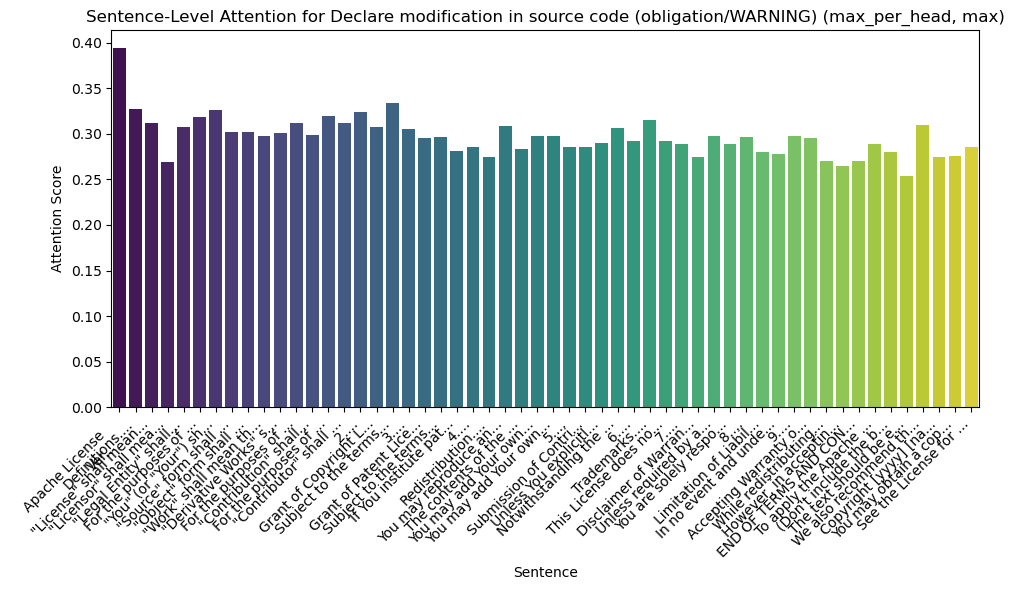

Sentence:  
Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1., Score: 0.394
Sentence: Definitions., Score: 0.327
Sentence: "License" shall mean the terms and conditions for use, reproduction, and distribution as defined by Sections 1 through 9 of this document., Score: 0.312
Sentence: "Licensor" shall mean the copyright owner or entity authorized by the copyright owner that is granting the License., Score: 0.269
Sentence: "Legal Entity" shall mean the union of the acting entity and all other entities that control, are controlled by, or are under common control with that entity., Score: 0.308
Sentence: For the purposes of this definition, "control" means (i) the power, direct or indirect, to cause the direction or management of such entity, whether by contract or otherwise, or (ii) ownership of fifty percent (50%) or more of the outstanding shares, or (iii) beneficial ownership of such entity., Scor

C:\Users\NPARSHO\AppData\Local\Temp\ipykernel_17412\3149208465.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(sentences)), y=[score for _, score in sentence_scores], palette="viridis")


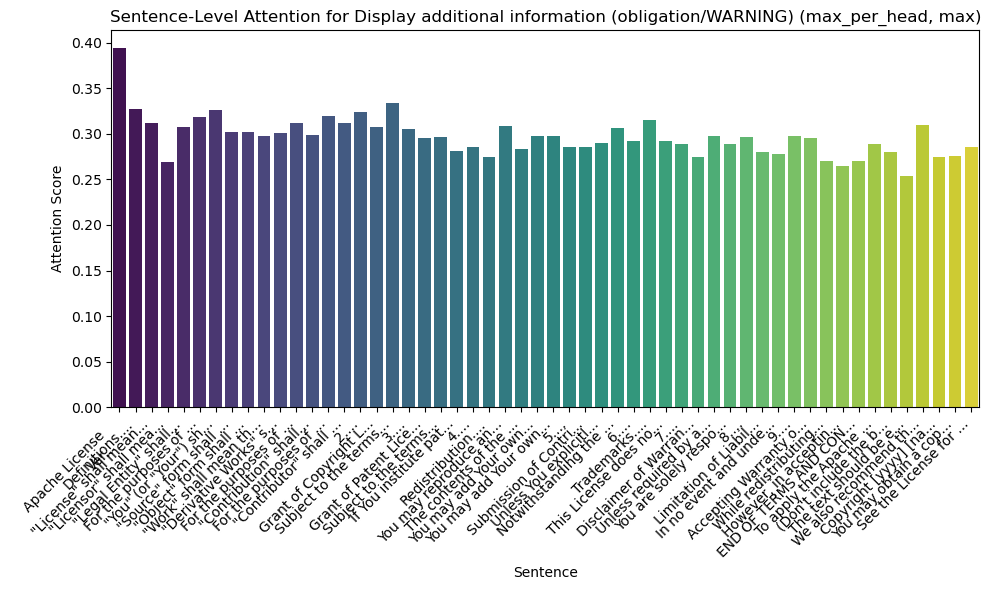

Sentence:  
Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1., Score: 0.394
Sentence: Definitions., Score: 0.327
Sentence: "License" shall mean the terms and conditions for use, reproduction, and distribution as defined by Sections 1 through 9 of this document., Score: 0.312
Sentence: "Licensor" shall mean the copyright owner or entity authorized by the copyright owner that is granting the License., Score: 0.269
Sentence: "Legal Entity" shall mean the union of the acting entity and all other entities that control, are controlled by, or are under common control with that entity., Score: 0.308
Sentence: For the purposes of this definition, "control" means (i) the power, direct or indirect, to cause the direction or management of such entity, whether by contract or otherwise, or (ii) ownership of fifty percent (50%) or more of the outstanding shares, or (iii) beneficial ownership of such entity., Scor

C:\Users\NPARSHO\AppData\Local\Temp\ipykernel_17412\3149208465.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(sentences)), y=[score for _, score in sentence_scores], palette="viridis")


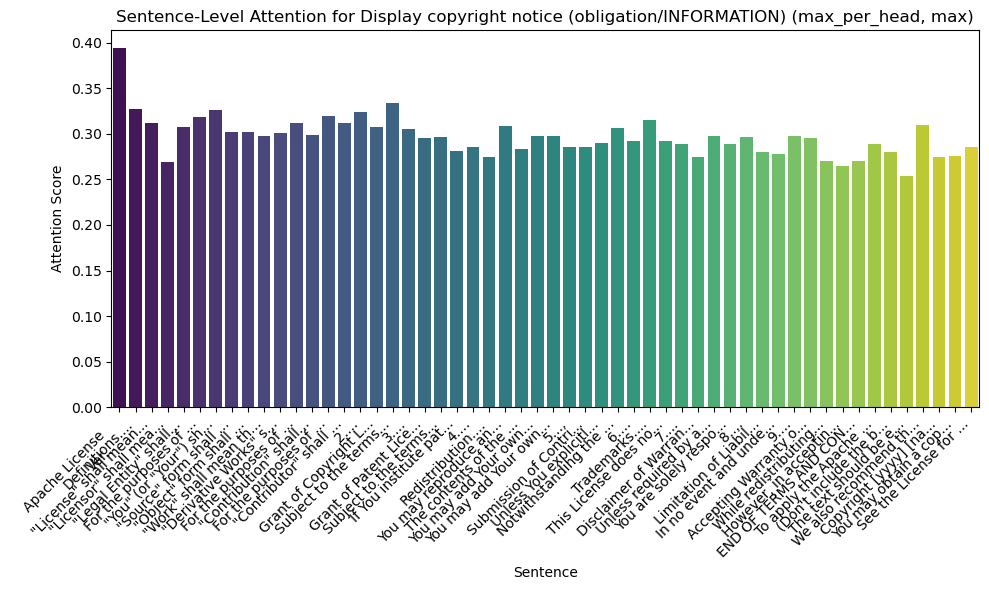

Sentence:  
Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1., Score: 0.394
Sentence: Definitions., Score: 0.327
Sentence: "License" shall mean the terms and conditions for use, reproduction, and distribution as defined by Sections 1 through 9 of this document., Score: 0.312
Sentence: "Licensor" shall mean the copyright owner or entity authorized by the copyright owner that is granting the License., Score: 0.269
Sentence: "Legal Entity" shall mean the union of the acting entity and all other entities that control, are controlled by, or are under common control with that entity., Score: 0.308
Sentence: For the purposes of this definition, "control" means (i) the power, direct or indirect, to cause the direction or management of such entity, whether by contract or otherwise, or (ii) ownership of fifty percent (50%) or more of the outstanding shares, or (iii) beneficial ownership of such entity., Scor

C:\Users\NPARSHO\AppData\Local\Temp\ipykernel_17412\3149208465.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(sentences)), y=[score for _, score in sentence_scores], palette="viridis")


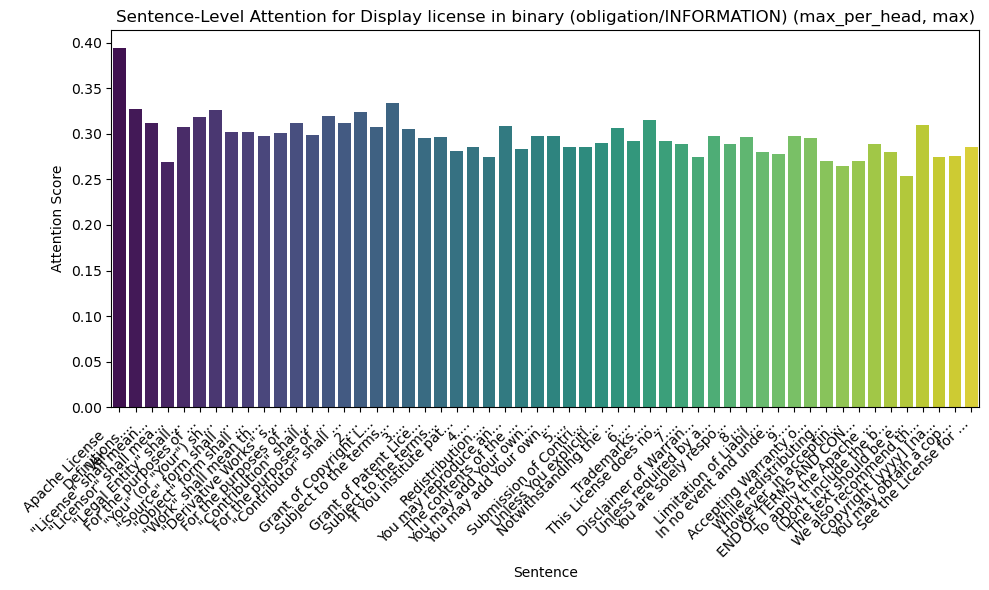

Sentence:  
Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1., Score: 0.394
Sentence: Definitions., Score: 0.327
Sentence: "License" shall mean the terms and conditions for use, reproduction, and distribution as defined by Sections 1 through 9 of this document., Score: 0.312
Sentence: "Licensor" shall mean the copyright owner or entity authorized by the copyright owner that is granting the License., Score: 0.269
Sentence: "Legal Entity" shall mean the union of the acting entity and all other entities that control, are controlled by, or are under common control with that entity., Score: 0.308
Sentence: For the purposes of this definition, "control" means (i) the power, direct or indirect, to cause the direction or management of such entity, whether by contract or otherwise, or (ii) ownership of fifty percent (50%) or more of the outstanding shares, or (iii) beneficial ownership of such entity., Scor

C:\Users\NPARSHO\AppData\Local\Temp\ipykernel_17412\3149208465.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(sentences)), y=[score for _, score in sentence_scores], palette="viridis")


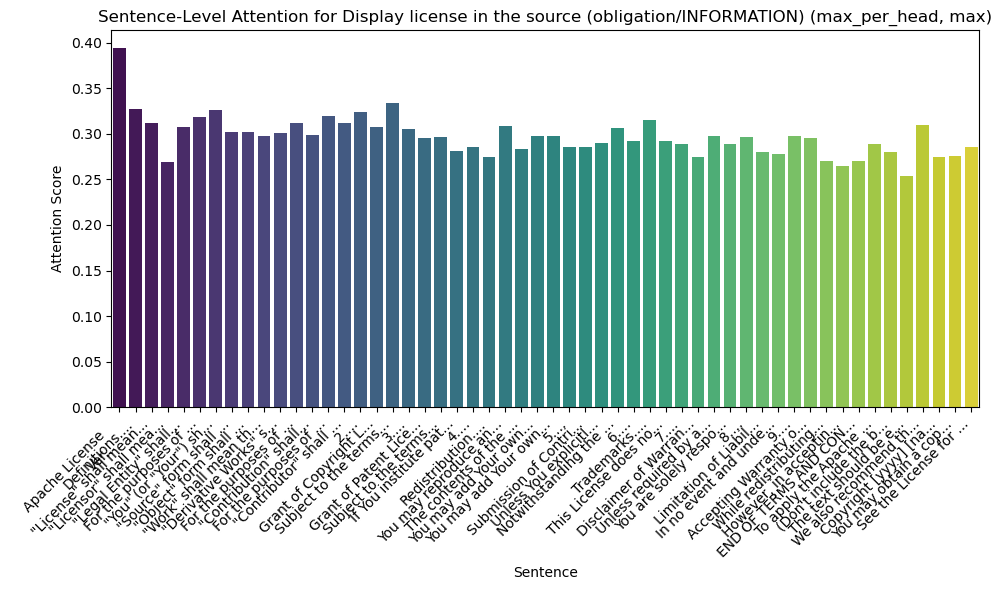

Sentence:  
Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1., Score: 0.394
Sentence: Definitions., Score: 0.327
Sentence: "License" shall mean the terms and conditions for use, reproduction, and distribution as defined by Sections 1 through 9 of this document., Score: 0.312
Sentence: "Licensor" shall mean the copyright owner or entity authorized by the copyright owner that is granting the License., Score: 0.269
Sentence: "Legal Entity" shall mean the union of the acting entity and all other entities that control, are controlled by, or are under common control with that entity., Score: 0.308
Sentence: For the purposes of this definition, "control" means (i) the power, direct or indirect, to cause the direction or management of such entity, whether by contract or otherwise, or (ii) ownership of fifty percent (50%) or more of the outstanding shares, or (iii) beneficial ownership of such entity., Scor

C:\Users\NPARSHO\AppData\Local\Temp\ipykernel_17412\3149208465.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(sentences)), y=[score for _, score in sentence_scores], palette="viridis")


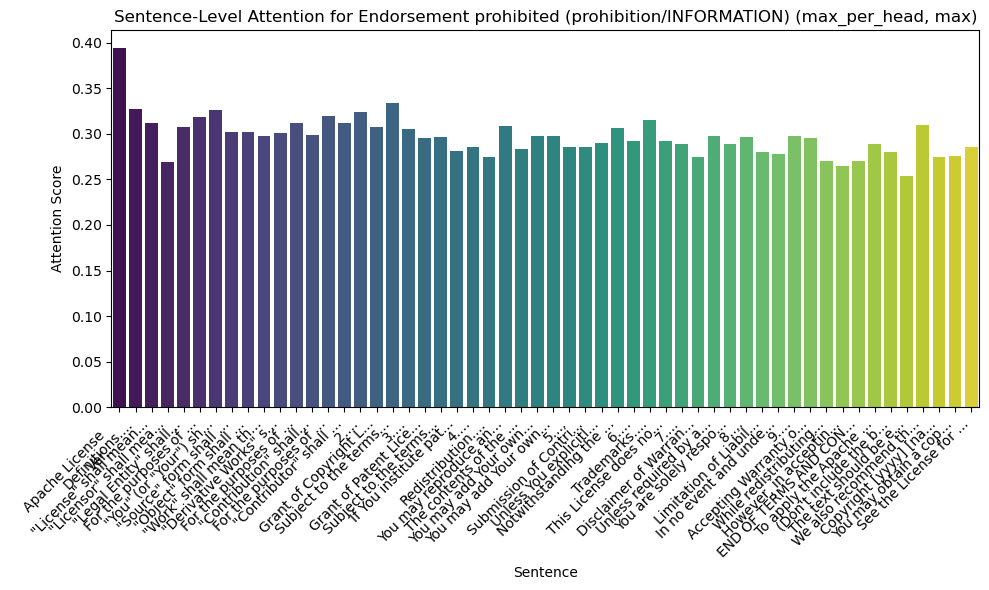

Sentence:  
Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1., Score: 0.394
Sentence: Definitions., Score: 0.327
Sentence: "License" shall mean the terms and conditions for use, reproduction, and distribution as defined by Sections 1 through 9 of this document., Score: 0.312
Sentence: "Licensor" shall mean the copyright owner or entity authorized by the copyright owner that is granting the License., Score: 0.269
Sentence: "Legal Entity" shall mean the union of the acting entity and all other entities that control, are controlled by, or are under common control with that entity., Score: 0.308
Sentence: For the purposes of this definition, "control" means (i) the power, direct or indirect, to cause the direction or management of such entity, whether by contract or otherwise, or (ii) ownership of fifty percent (50%) or more of the outstanding shares, or (iii) beneficial ownership of such entity., Scor

C:\Users\NPARSHO\AppData\Local\Temp\ipykernel_17412\3149208465.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(sentences)), y=[score for _, score in sentence_scores], palette="viridis")


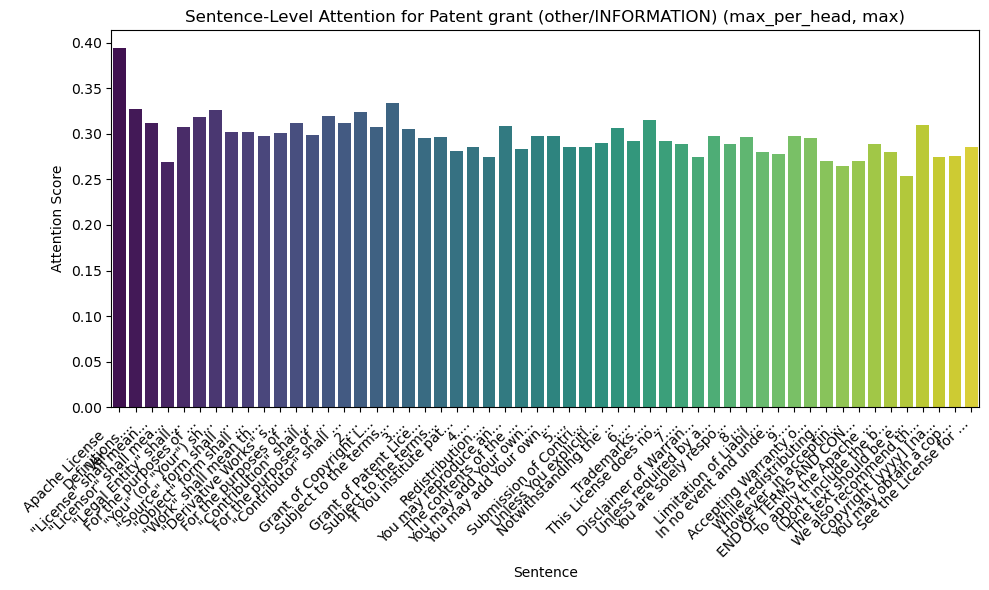

Sentence:  
Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1., Score: 0.394
Sentence: Definitions., Score: 0.327
Sentence: "License" shall mean the terms and conditions for use, reproduction, and distribution as defined by Sections 1 through 9 of this document., Score: 0.312
Sentence: "Licensor" shall mean the copyright owner or entity authorized by the copyright owner that is granting the License., Score: 0.269
Sentence: "Legal Entity" shall mean the union of the acting entity and all other entities that control, are controlled by, or are under common control with that entity., Score: 0.308
Sentence: For the purposes of this definition, "control" means (i) the power, direct or indirect, to cause the direction or management of such entity, whether by contract or otherwise, or (ii) ownership of fifty percent (50%) or more of the outstanding shares, or (iii) beneficial ownership of such entity., Scor

C:\Users\NPARSHO\AppData\Local\Temp\ipykernel_17412\3149208465.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(sentences)), y=[score for _, score in sentence_scores], palette="viridis")


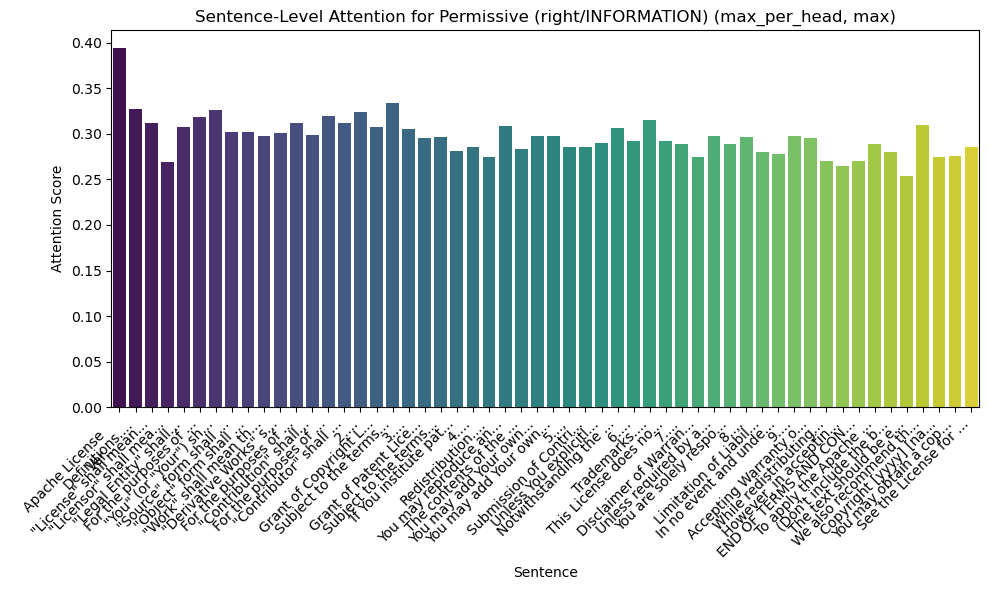

Sentence:  
Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1., Score: 0.394
Sentence: Definitions., Score: 0.327
Sentence: "License" shall mean the terms and conditions for use, reproduction, and distribution as defined by Sections 1 through 9 of this document., Score: 0.312
Sentence: "Licensor" shall mean the copyright owner or entity authorized by the copyright owner that is granting the License., Score: 0.269
Sentence: "Legal Entity" shall mean the union of the acting entity and all other entities that control, are controlled by, or are under common control with that entity., Score: 0.308
Sentence: For the purposes of this definition, "control" means (i) the power, direct or indirect, to cause the direction or management of such entity, whether by contract or otherwise, or (ii) ownership of fifty percent (50%) or more of the outstanding shares, or (iii) beneficial ownership of such entity., Scor

C:\Users\NPARSHO\AppData\Local\Temp\ipykernel_17412\3149208465.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(sentences)), y=[score for _, score in sentence_scores], palette="viridis")


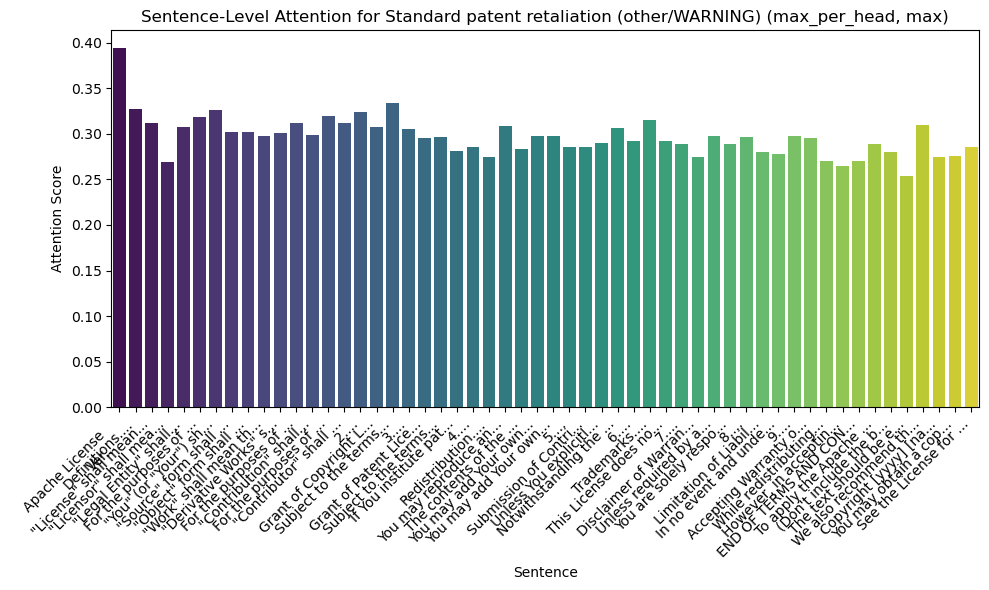

Sentence:  
Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1., Score: 0.394
Sentence: Definitions., Score: 0.327
Sentence: "License" shall mean the terms and conditions for use, reproduction, and distribution as defined by Sections 1 through 9 of this document., Score: 0.312
Sentence: "Licensor" shall mean the copyright owner or entity authorized by the copyright owner that is granting the License., Score: 0.269
Sentence: "Legal Entity" shall mean the union of the acting entity and all other entities that control, are controlled by, or are under common control with that entity., Score: 0.308
Sentence: For the purposes of this definition, "control" means (i) the power, direct or indirect, to cause the direction or management of such entity, whether by contract or otherwise, or (ii) ownership of fifty percent (50%) or more of the outstanding shares, or (iii) beneficial ownership of such entity., Scor

C:\Users\NPARSHO\AppData\Local\Temp\ipykernel_17412\3149208465.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(sentences)), y=[score for _, score in sentence_scores], palette="viridis")


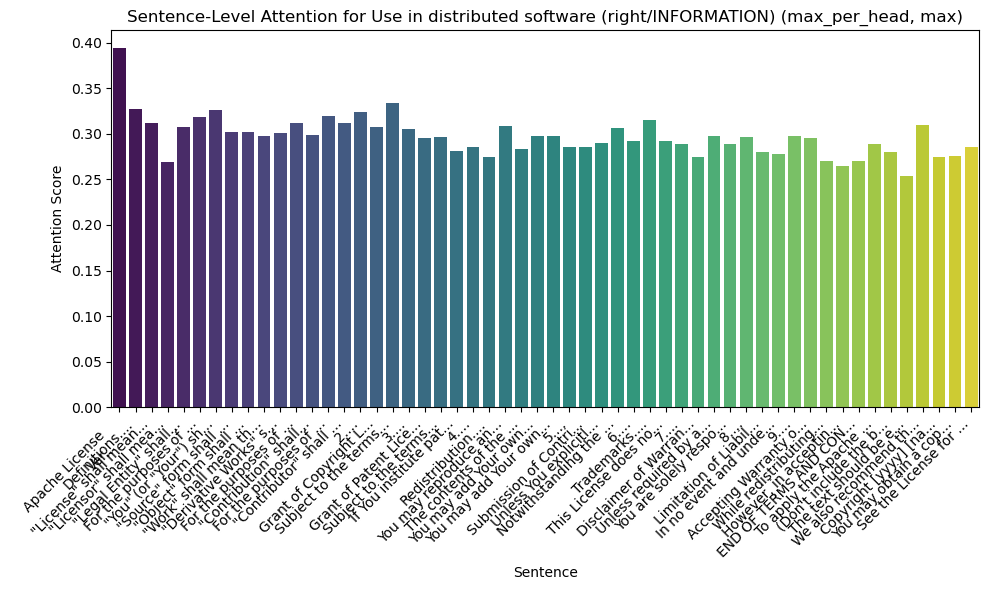

Sentence:  
Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1., Score: 0.394
Sentence: Definitions., Score: 0.327
Sentence: "License" shall mean the terms and conditions for use, reproduction, and distribution as defined by Sections 1 through 9 of this document., Score: 0.312
Sentence: "Licensor" shall mean the copyright owner or entity authorized by the copyright owner that is granting the License., Score: 0.269
Sentence: "Legal Entity" shall mean the union of the acting entity and all other entities that control, are controlled by, or are under common control with that entity., Score: 0.308
Sentence: For the purposes of this definition, "control" means (i) the power, direct or indirect, to cause the direction or management of such entity, whether by contract or otherwise, or (ii) ownership of fifty percent (50%) or more of the outstanding shares, or (iii) beneficial ownership of such entity., Scor

In [36]:
aggregation_method = "max_per_head"  # "average", "max_per_head", "max_per_layer", "all"
sentence_aggregation = "max"  # "average", "max", "sum"

# Pass *both* original and preprocessed text, along with attention mask
visualize_sentence_attention(license_text, preprocessed_license, attentions, predicted_labels, encoded_input, attention_mask, aggregation_method, sentence_aggregation)
print("Attention visualization complete.")

In [37]:
def get_top_sentences_per_label(text, preprocessed_text, attentions, predicted_labels, encoded_input, attention_mask, aggregation_method="max_per_head", sentence_aggregation="max", top_k=3):
    """
    Returns a dictionary: {label: [sentence1, sentence2, ...]}
    """
    sentences = sent_tokenize(text)
    preprocessed_sentences = [preprocess_text(s) for s in sentences]

    all_tokens = tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][0])
    tokens = [token for token in all_tokens if token != "[PAD]"][1:-1]
    true_seq_len = len(tokens)

    num_layers = len(attentions)
    num_heads = attentions[0].shape[1]

    token_to_sentence_mapping = []
    current_sentence_index = 0
    current_token_index = 0
    sentence_tokens = tokenizer.tokenize(preprocessed_sentences[current_sentence_index])

    for i, token in enumerate(tokens):
        if current_token_index < len(sentence_tokens) and token == sentence_tokens[current_token_index]:
            token_to_sentence_mapping.append(current_sentence_index)
            current_token_index += 1
        elif current_token_index < len(sentence_tokens) and token.startswith("##") and sentence_tokens[current_token_index].startswith("##") and token[2:] == sentence_tokens[current_token_index][2:]:
            token_to_sentence_mapping.append(current_sentence_index)
            current_token_index += 1
        elif current_token_index < len(sentence_tokens) and token.startswith("##") and (token[2:] in sentence_tokens[current_token_index]):
            token_to_sentence_mapping.append(current_sentence_index)
            current_token_index += 1
        else:
            current_sentence_index += 1
            if current_sentence_index < len(sentences):
                sentence_tokens = tokenizer.tokenize(preprocessed_sentences[current_sentence_index])
                token_to_sentence_mapping.append(current_sentence_index)
                current_token_index = 1
            else:
                token_to_sentence_mapping.append(current_sentence_index - 1)

    attention_mask = attention_mask.squeeze(0)
    valid_indices = attention_mask.nonzero().squeeze()
    valid_indices = valid_indices[(valid_indices != 0) & (valid_indices != valid_indices[-1])]
    valid_indices = valid_indices - 1

    result_dict = {}

    for label_index, label in enumerate(predicted_labels[0]):
        if aggregation_method == "average":
            aggregated_attention = torch.zeros(true_seq_len, device=device)
            for layer in range(num_layers):
                attn = attentions[layer][0]
                avg_heads = torch.mean(attn, dim=0)
                valid_attn = avg_heads[valid_indices, :][:, valid_indices]
                aggregated_attention += torch.mean(valid_attn, dim=1)
            aggregated_attention /= num_layers

        elif aggregation_method == "max_per_head":
            aggregated_attention = torch.zeros(true_seq_len, device=device)
            for layer in range(num_layers):
                attn = attentions[layer][0]
                valid_attn = attn[:, valid_indices, :][:, :, valid_indices]
                max_head_values, _ = torch.max(valid_attn, dim=2)
                avg_heads = torch.mean(max_head_values, dim=0)
                aggregated_attention += avg_heads
            aggregated_attention /= num_layers

        elif aggregation_method == "max_per_layer":
            aggregated_attention = torch.zeros(true_seq_len, device=device)
            for layer in range(num_layers):
                attn = attentions[layer][0]
                valid_attn = attn[:, valid_indices, :][:, :, valid_indices]
                avg_heads = torch.mean(valid_attn, dim=0)
                max_layer_value, _ = torch.max(avg_heads, dim=1)
                aggregated_attention += max_layer_value
            aggregated_attention /= num_layers

        elif aggregation_method == "all":
            aggregated_attentions = []
            for layer in range(num_layers):
                layer_attentions = []
                for head in range(num_heads):
                    attn = attentions[layer][0, head].cpu().numpy()
                    valid_attn = attn[valid_indices.cpu().numpy(), :][:, valid_indices.cpu().numpy()]
                    layer_attentions.append(valid_attn)
                aggregated_attentions.append(layer_attentions)
        else:
            raise ValueError("Invalid aggregation_method.")

        sentence_scores = []
        if aggregation_method != "all":
            attention_values = aggregated_attention.cpu().numpy()
            for sent_idx in range(len(sentences)):
                indices = [i for i, x in enumerate(token_to_sentence_mapping) if x == sent_idx]
                if indices:
                    if sentence_aggregation == "average":
                        sentence_score = np.mean(attention_values[indices])
                    elif sentence_aggregation == "max":
                        sentence_score = np.max(attention_values[indices])
                    elif sentence_aggregation == "sum":
                        sentence_score = np.sum(attention_values[indices])
                    else:
                        raise ValueError("Invalid sentence_aggregation method.")
                else:
                    sentence_score = 0.0
                sentence_scores.append((sentences[sent_idx], sentence_score))  # Original sentence

            sentence_scores.sort(key=lambda x: x[1], reverse=True)
            top_sentences = [sentence for sentence, _ in sentence_scores[:top_k]]
            result_dict[label] = top_sentences
        else:
            # Handle the 'all' case (return sentence scores with original sentences)
            for layer in range(num_layers):
                for head in range(num_heads):
                    sentence_scores = []
                    attention_values = aggregated_attentions[layer][head][:, label_index]
                    for sent_idx in range(len(sentences)):
                        indices = [i for i, x in enumerate(token_to_sentence_mapping) if x == sent_idx]
                        if indices:
                            if sentence_aggregation == "average":
                                sentence_score = np.mean(attention_values[indices])
                            elif sentence_aggregation == "max":
                                sentence_score = np.max(attention_values[indices])
                            elif sentence_aggregation == "sum":
                                sentence_score = np.sum(attention_values[indices])
                            else:
                                raise ValueError("Invalid sentence_aggregation method")
                        else:
                            sentence_score = 0.0
                        sentence_scores.append((sentences[sent_idx], sentence_score))
            result_dict[label] = [sent[0] for sent in sentence_scores]  # Keep all sentences with 'all'

    return result_dict

In [38]:
aggregation_method = "max_per_head"
sentence_aggregation = "max"
top_k = 3

result = get_top_sentences_per_label(license_text, preprocessed_license, attentions, predicted_labels, encoded_input, attention_mask, aggregation_method, sentence_aggregation, top_k)

C:\Users\NPARSHO\AppData\Local\Temp\ipykernel_17412\2807973039.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [39]:
for label, sentences in result.items():
    print(f"\nTop {top_k} Sentences associated with {label}:")
    for sentence in sentences:
        print(f"- {sentence}")


Top 3 Sentences associated with Declare modification in source code (obligation/WARNING):
-  
Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1.
- Subject to the terms and conditions of this License, each Contributor hereby grants to You a perpetual, worldwide, non-exclusive, no-charge, royalty-free, irrevocable copyright license to reproduce, prepare Derivative Works of, publicly display, publicly perform, sublicense, and distribute the Work and such Derivative Works in Source or Object form.
- Definitions.

Top 3 Sentences associated with Display additional information (obligation/WARNING):
-  
Apache License
Version 2.0, January 2004
http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1.
- Subject to the terms and conditions of this License, each Contributor hereby grants to You a perpetual, worldwide, non-exclusive, no-charge, royalty-free, irrevocable